In [179]:
import torch
from uwnet.thermo import lhf_to_evap
ds = xr.open_dataset("../data/processed/training.nc").isel(time=slice(0, 120), step=0)
index = pd.date_range(start='1990', periods=len(ds.time), freq='3H')
index = index - index[0]
ds['time'] = index

In [182]:
model  = torch.load("../models/268/5.pkl")

In [183]:
out = model.call_with_xr(ds)

In [185]:
FPNN = -(out.QT  * ds.layer_mass).sum('z')/1000

In [186]:
net_precip = ds.Prec - lhf_to_evap(ds.LHF)

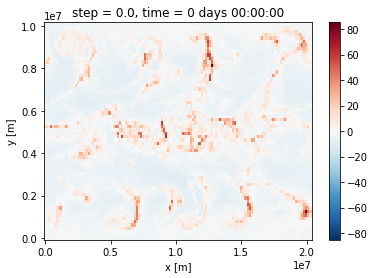

In [187]:
FPNN[0].plot()

In [188]:
len(FPNN.to_series())

983040

In [189]:
def compare_pdf(FPNN, net_precip):
    FPNN.to_series()[::50].plot(kind='kde', logy=True, label='Network')
    net_precip.to_series()[::50].plot(kind='kde', logy=True, label='Truth')
    plt.xlim([0, 100])
    plt.ylim([1e-6, 1])
    plt.legend()

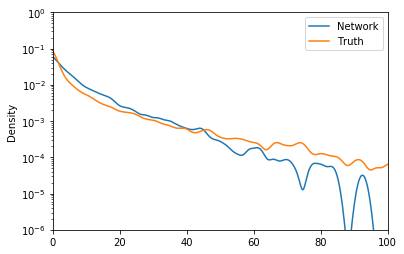

In [190]:
compare_pdf(FPNN, net_precip)

The tails are much fatter in the truth

This is also true for daily averaged data:

(0.0001, 0.1)

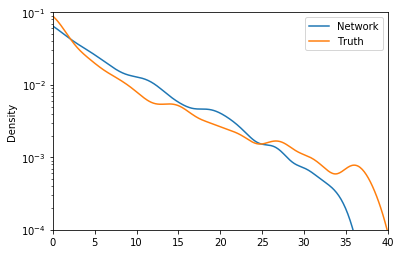

In [191]:
daily_fpnn = FPNN.resample(time='D').mean('time')
daily_ep = net_precip.resample(time='D').mean('time')

compare_pdf(daily_fpnn, daily_ep)
plt.xlim([0, 40])
plt.ylim([ 1e-4, 1e-1,])

# Debug

In [135]:
kwargs = torch.load("../data/runs/model269-epoch4/debug.pkl")

In [136]:
from uwnet.numpy_interface import call_with_numpy_dict

In [137]:
out = call_with_numpy_dict(model, kwargs)

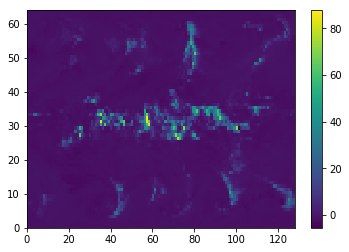

In [151]:
plt.pcolormesh(out['SLI'][15,:,:])
plt.colorbar()

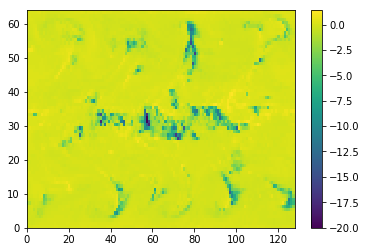

In [157]:
plt.pcolormesh(out['QV'][15,:,:])
plt.colorbar()

In [140]:
kwargs['SLI'].shape

(34, 64, 128)

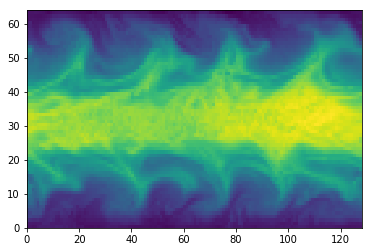

In [141]:
plt.pcolormesh(kwargs['QV'][0,:,:])

# Time scale of humidiy

In [167]:
qv_stor = ds.QV.diff('time')/.125

num = (ds.QV * ds.FQT).groupby('z').sum()
denom = (ds.QV * ds.QV).groupby('z').sum()
coef = num/denom * 86400

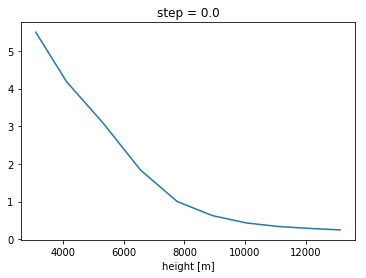

In [178]:
(1/coef[12:22]).plot()